# Passing networks' report of England during the EURO

### Prepare the Data

In [204]:
# Import the required libraries
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.colors import to_rgba
import seaborn as sns
from sklearn import preprocessing

# Get all competitions
competitionsDB = pd.DataFrame(sb.competitions())
# Filter only the 2022 women's euro, id is 53
women_euro = competitionsDB[competitionsDB['competition_id'] == 53]

# Get the England's matches, 53 is competition_id and 106 is season_id
games = sb.matches(53, 106)
england_games = games[(games['home_team'] == "England Women's") | (games['away_team'] == "England Women's")]
assert len(england_games) == 6

england_games_ids = [game[1]['match_id'] for game in england_games.iterrows()]

We have the references of all the england's games, let's compute the principal passing networks first

In [205]:
def compute_passing_networks(match_id):
    """"""
    # Source : https://betterprogramming.pub/how-to-visualize-football-passing-networks-using-python-6f6582aa8005

    # Get the events of the game
    game_events = sb.events(match_id)

    # Get the opponent team's name
    opponent_name = [name for name in np.unique(game_events.team.tolist()) if name != "England Women's"][0]

    # Filter the passes events
    pass_raw = game_events[game_events.type == 'Pass']

    pass_number_raw = pass_raw[['timestamp', 'player', 'pass_recipient']]

    # Create identifier to allow counting
    pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient

    # Count the most paired players
    pass_count = pass_number_raw.groupby(['pair']).count().reset_index()
    pass_count = pass_count[['pair', 'timestamp']]
    pass_count.columns = ['pair', 'number_pass']

    # Get the average's positions of players
    avg_loc_df = pass_raw[['team', 'player', 'location']]

    avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
    avg_loc_df['pos_y'] = avg_loc_df.location.apply(lambda x: x[1])
    avg_loc_df = avg_loc_df.drop('location', axis=1)

    # Average player positions
    avg_loc_df = avg_loc_df.groupby(['team','player']).agg({'pos_x': np.mean, 'pos_y': np.mean}).reset_index()

    pass_merge = pass_number_raw.merge(pass_count, on='pair')
    pass_merge = pass_merge[['player', 'pass_recipient', 'number_pass']]
    pass_merge = pass_merge.drop_duplicates()

    avg_loc_df = avg_loc_df[['player', 'pos_x', 'pos_y']]

    # Data processing
    pass_cleaned = pass_merge.merge(avg_loc_df, on='player')
    pass_cleaned.rename({'pos_x': 'pos_x_start', 'pos_y': 'pos_y_start'}, axis='columns', inplace=True)

    pass_cleaned = pass_cleaned.merge(avg_loc_df, left_on='pass_recipient', right_on='player', suffixes=['', '_end'])
    pass_cleaned.rename({'pos_x': 'pos_x_end', 'pos_y': 'pos_y_end'}, axis='columns', inplace=True)

    # Get the players with the most minutes played
    eng_player_df = game_events[game_events.team == "England Women's"].groupby('player').agg({'minute': [min, max]}).reset_index()
    eng_player_df = pd.concat([eng_player_df['player'], eng_player_df['minute']], axis=1)
    eng_player_df['minutes_played'] = eng_player_df['max'] - eng_player_df['min']
    eng_player_df = eng_player_df.sort_values('minutes_played', ascending=False)

    # Filter the best 11
    eng_player_names = eng_player_df.player[:11].tolist()

    pass_eng = pass_cleaned[pass_cleaned.player.isin(eng_player_names)]
    pass_eng = pass_eng[pass_eng.pass_recipient.isin(eng_player_names)]

    # Prepare the plot
    pass_eng['width'] = pass_eng['number_pass'] / pass_eng['number_pass'].max()
    pass_eng['width'] = pass_eng['width'] * pass_eng['width'] * 2

    # Plot the graph
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(pass_eng), 1))
    c_transparency = pass_eng.number_pass / pass_eng.number_pass.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False,
                          title_space=0, grid_height=0.82, endnote_height=0.05)

    fig.set_facecolor("#22312b")
    pass_lines = pitch.lines(pass_eng.pos_x_start, pass_eng.pos_y_start,
                             pass_eng.pos_x_end, pass_eng.pos_y_end, lw=pass_eng.width+0.5,
                             color=color, zorder=1, ax=axs['pitch'])

    pass_nodes = pitch.scatter(pass_eng.pos_x_start, pass_eng.pos_y_start, s=450,
                               color='red', edgecolors='black', linewidth=1, alpha=1, ax=axs['pitch'])

    for index, row in pass_eng.iterrows():
        pitch.annotate(row.player, xy=(row.pos_x_start-3, row.pos_y_start-3), c='white', va='center',
                       ha='center', size=12, ax=axs['pitch'])

    # endnote /title
    axs['endnote'].text(1, 0.5, 'Digitalization in Sports', color='#c7d5cc',
                        va='center', ha='right', fontsize=15)

    axs['endnote'].text(0.5, 0.9, 'Attacking Direction', va='center', ha='center', color='#c7d5cc', fontsize=12)
    axs['endnote'].arrow(0.4, 0.6, 0.2, 0, head_width=0.25, head_length=0.025, ec='w', fc='w')
    axs['endnote'].set_xlim(0, 1)
    axs['endnote'].set_ylim(0, 1)

    axs['title'].text(0.5, 0.7, 'Passing Networks by England', color='#c7d5cc',
                      va='center', ha='center', fontsize=30)
    axs['title'].text(0.5, 0.25, 'vs ' + opponent_name, color='#c7d5cc',
                      va='center', ha='center', fontsize=18)
    plt.savefig('visualizations/Passes/Passing Networks_'+opponent_name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\1523747539.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['pair'] = pass_number_raw.player + pass_number_raw.pass_recipient
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\1523747539.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_loc_df['pos_x'] = avg_loc_df.location.apply(lambda x: x[0])
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\1523747539.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

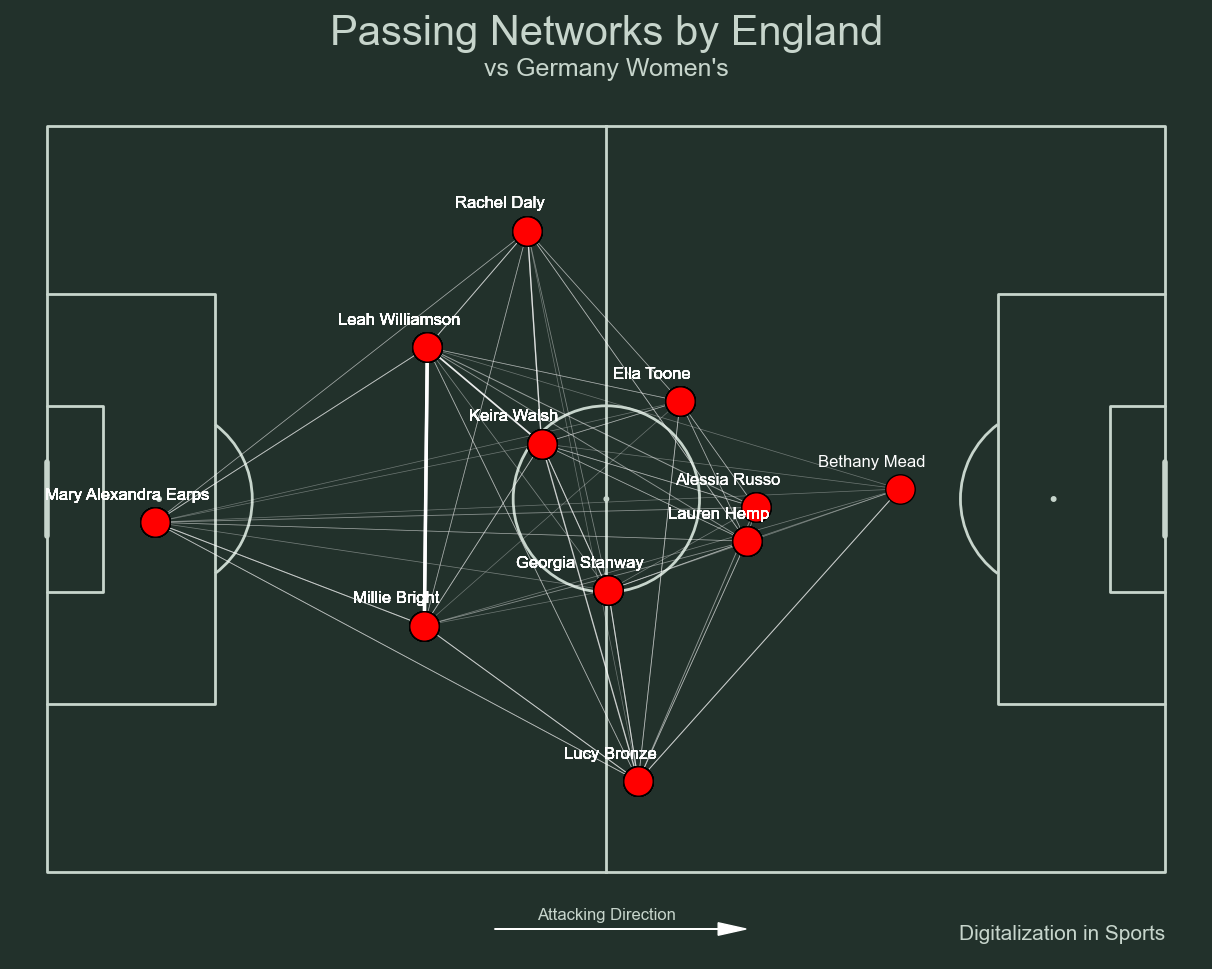

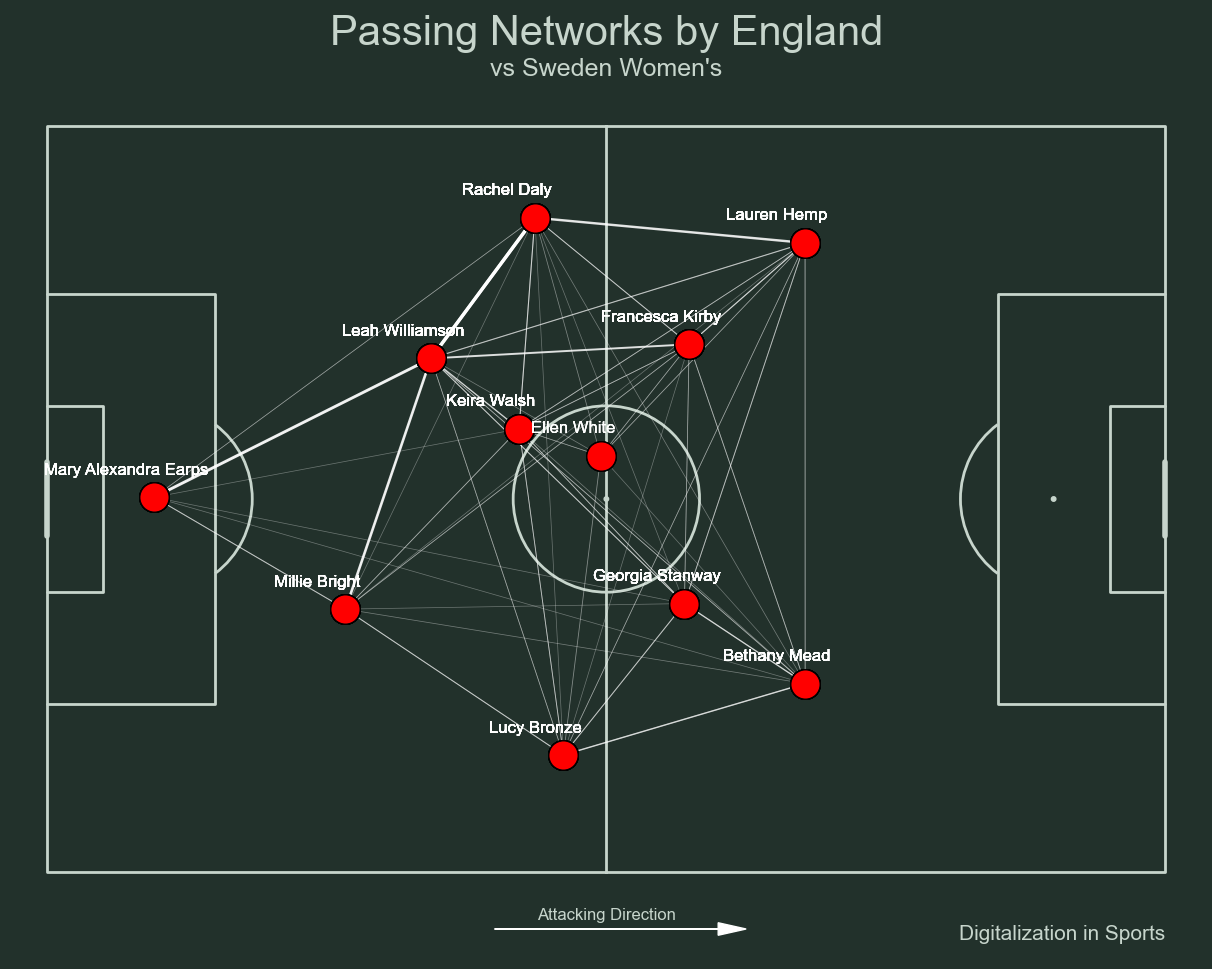

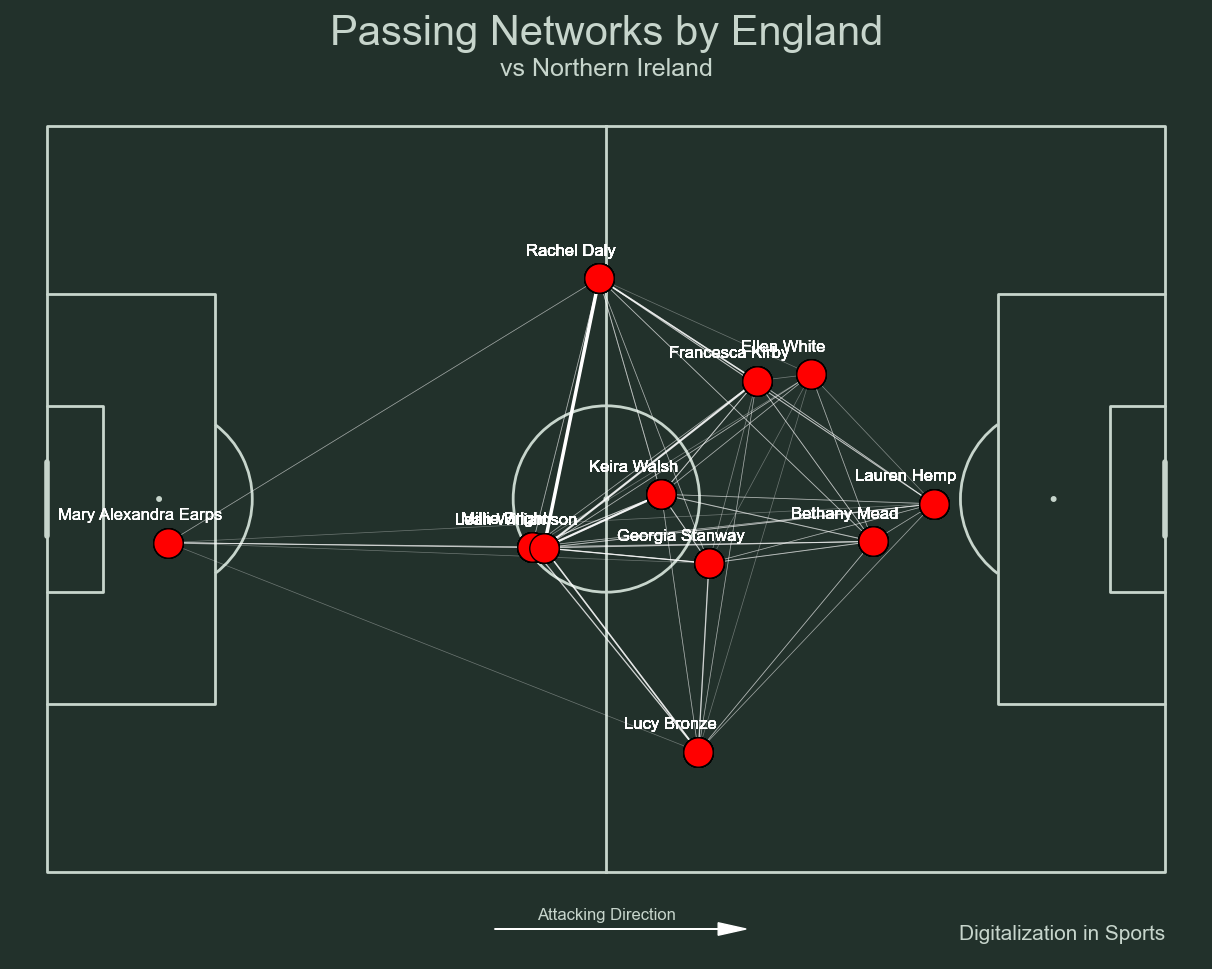

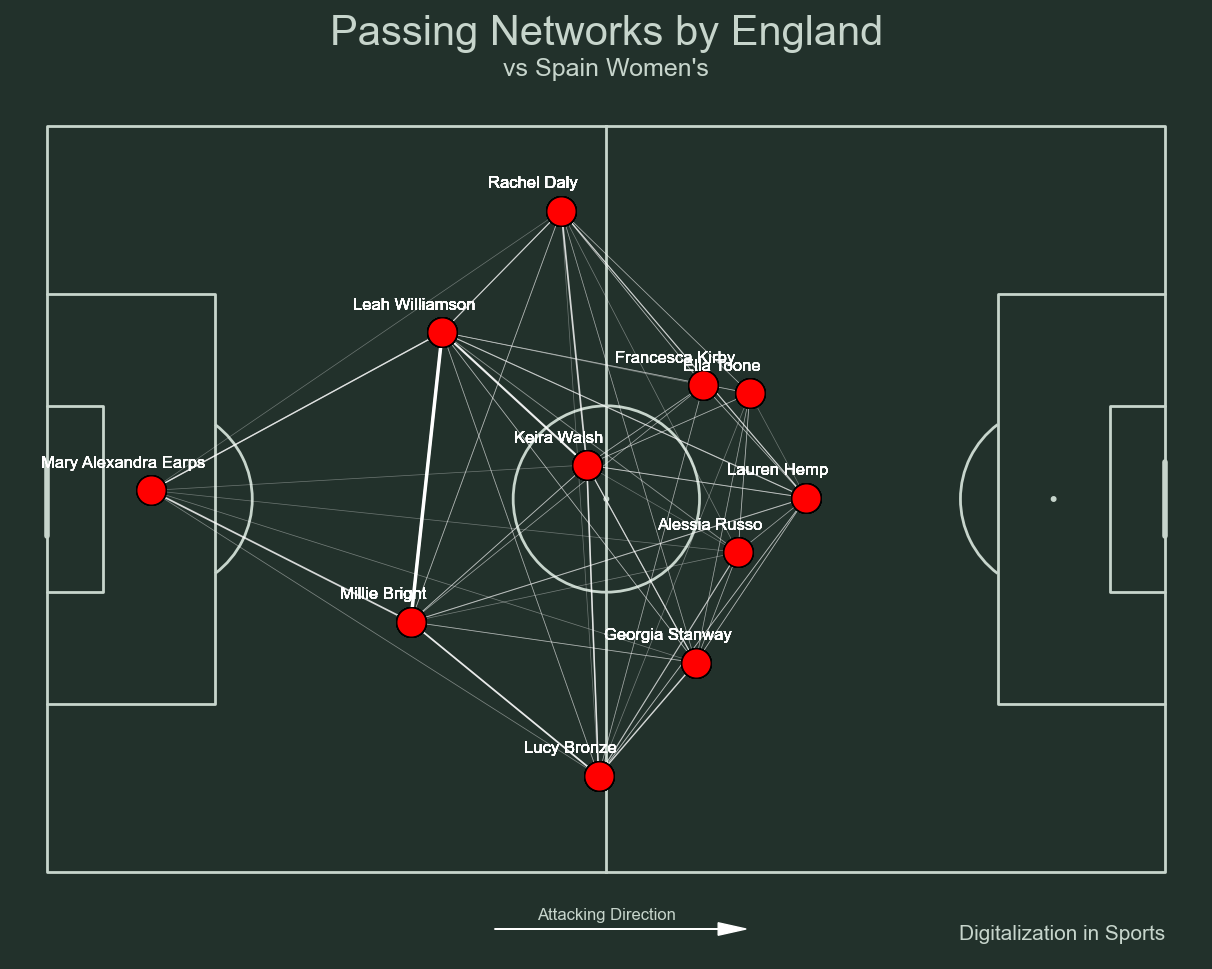

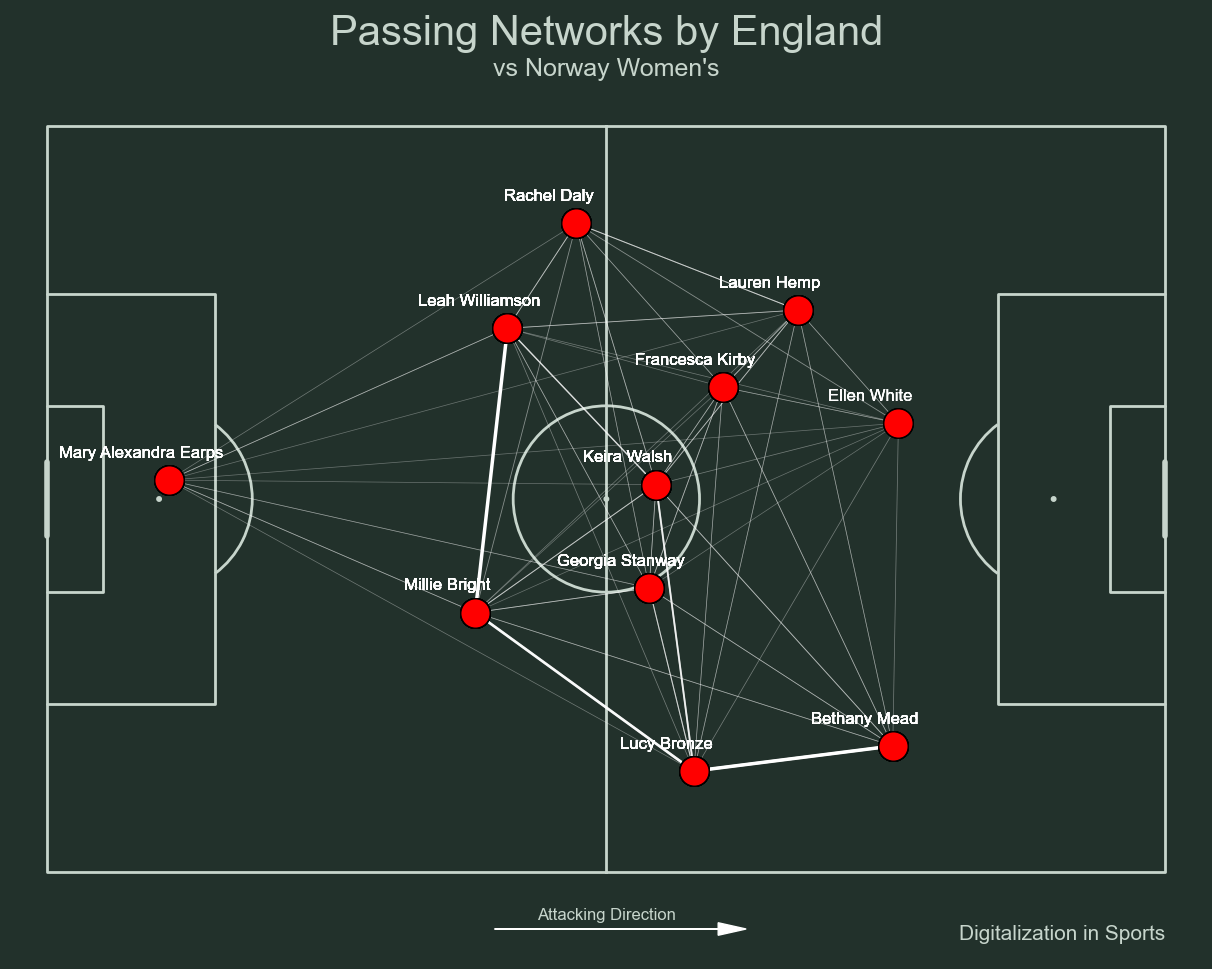

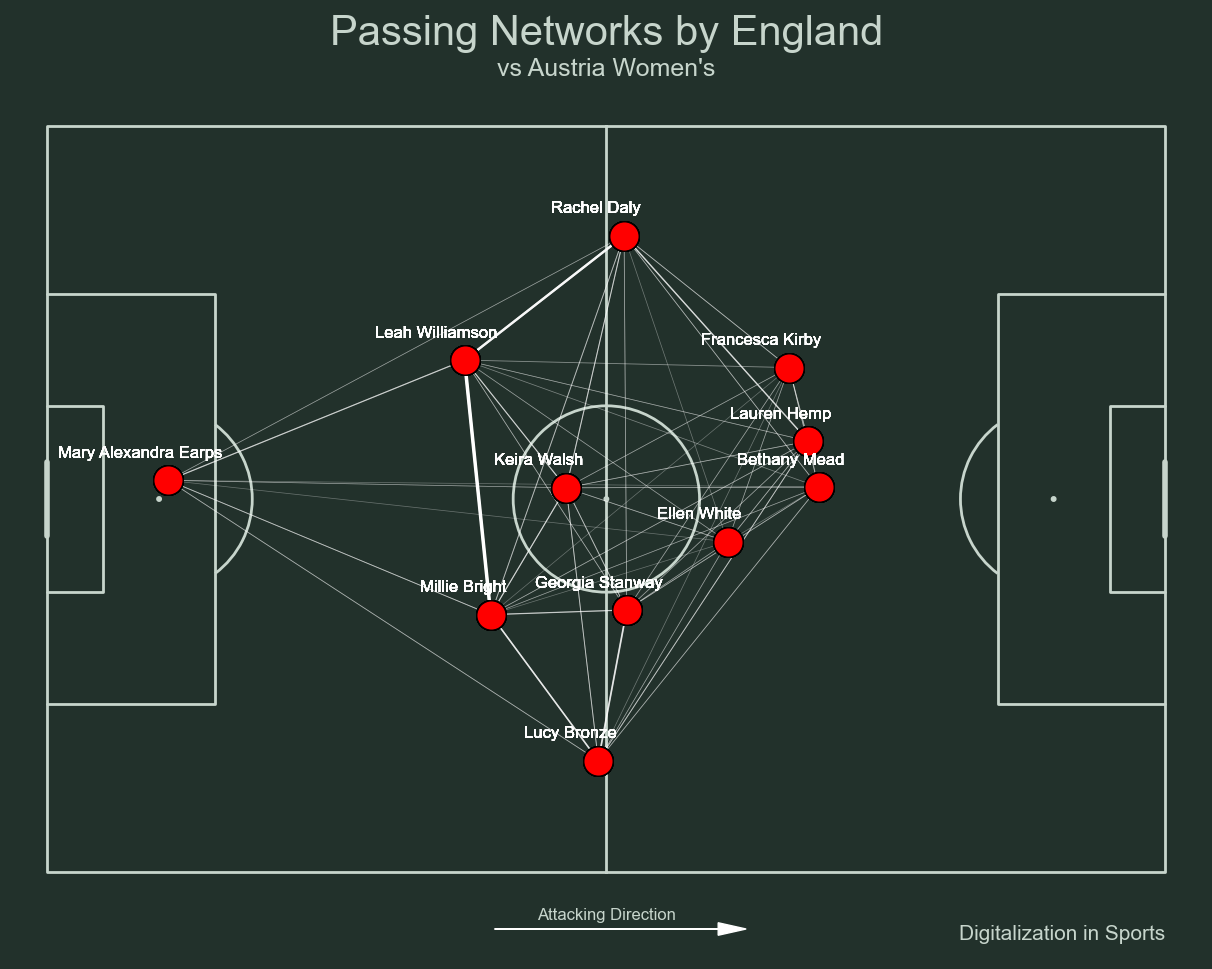

In [206]:
for i in range(6):
    compute_passing_networks(england_games_ids[i])

Let's plot the Passes per 90 vs % accuracy passes chart for each team in the competition

In [207]:
# Let's get all the ids of the games
games_ids = [game[1]['match_id'] for game in games.iterrows()]

# Initialize the DF
passes_df = pd.DataFrame(columns=['team', 'passes_number/90', '%_accuracy', 'assists/90'])

for id in games_ids:

    # For each game, get the home_team and the away team
    home_team = str(games[games.match_id == id]['home_team'].values[0])
    away_team = str(games[games.match_id == id]['away_team'].values[0])

    # Get the events of the game and filter only the passes
    events = sb.events(id)
    passes_events = events[events.type == 'Pass']
    # Get the number of minutes of the game
    minute_played = max(events['minute'])

    # Discriminate the passes for home team and away_team
    passes_events_home = passes_events[passes_events.team == home_team]
    passes_events_away = passes_events[passes_events.team == away_team]

    # Get the assist for each team
    if 'pass_goal_assist' in passes_events_home.keys():
        assists_home = passes_events_home[passes_events_home['pass_goal_assist'] == True]
        assists_away = passes_events_away[passes_events_away['pass_goal_assist'] == True]

    # Get the successful passes for each team
    passes_events_home_success = passes_events_home[passes_events_home['pass_outcome'].isna()]
    passes_events_away_success = passes_events_away[passes_events_away['pass_outcome'].isna()]

    # Divide number of passes per number of successful passes
    percent_success_home = (len(passes_events_home_success) / len(passes_events_home)) * 100
    percent_success_away = (len(passes_events_away_success) / len(passes_events_away)) * 100

    # Divide number of passes per minutes played
    passes_per_90_home = len(passes_events_home) * 90 / minute_played
    passes_per_90_away = len(passes_events_away) * 90 / minute_played

    # Divide assists per 90
    assists_per_90_home = len(assists_home) * 90 / minute_played
    assists_per_90_away = len(assists_away) * 90 / minute_played

    # Add to Dataframe
    home_series = pd.Series({'team': home_team, 'passes_number/90' : passes_per_90_home, '%_accuracy' : percent_success_home, 'assists/90' : assists_per_90_home})
    away_series = pd.Series({'team': away_team, 'passes_number/90' : passes_per_90_away, '%_accuracy' : percent_success_away, 'assists/90' : assists_per_90_away})

    passes_df = passes_df.append(home_series, ignore_index=True) ; passes_df = passes_df.append(away_series, ignore_index = True)

# Group by team and compute the mean
passes_df = passes_df.groupby(['team']).mean()
print(passes_df)

C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\3264575964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  passes_df = passes_df.append(home_series, ignore_index=True) ; passes_df = passes_df.append(away_series, ignore_index = True)
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\3264575964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  passes_df = passes_df.append(home_series, ignore_index=True) ; passes_df = passes_df.append(away_series, ignore_index = True)
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\3264575964.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  passes_df = passes_df.append(home_series, ignore_index=True) ; passes_df = passes_df.append(away_series, ignore_index = True)
C:\Users\axel

                     passes_number/90  %_accuracy  assists/90
team                                                         
Austria Women's            381.927613   68.591545    0.478723
Belgium Women's            427.886723   73.909094    0.468801
Denmark Women's            393.774283   66.370607    0.319149
England Women's            505.540415   79.776673    2.151586
France Women's             492.426465   81.291926    1.414747
Germany Women's            457.396166   74.278238    1.562662
Iceland Women's            315.051000   63.494877    0.319149
Italy Women's              453.525212   76.895363    0.635081
Netherlands Women's        456.468394   79.926238    0.703276
Northern Ireland           264.610676   65.527748    0.000000
Norway Women's             475.075209   77.550220    0.631579
Portugal Women's           370.174552   72.639184    0.628289
Spain Women's              669.723132   84.362545    1.144102
Sweden Women's             435.587208   73.064383    1.143016
Switzerl

                   team  passes_number/90  %_accuracy  assists/90
0       Austria Women's        381.927613   68.591545    0.478723
1       Belgium Women's        427.886723   73.909094    0.468801
2       Denmark Women's        393.774283   66.370607    0.319149
3       England Women's        505.540415   79.776673    2.151586
4        France Women's        492.426465   81.291926    1.414747
5       Germany Women's        457.396166   74.278238    1.562662
6       Iceland Women's        315.051000   63.494877    0.319149
7         Italy Women's        453.525212   76.895363    0.635081
8   Netherlands Women's        456.468394   79.926238    0.703276
9      Northern Ireland        264.610676   65.527748    0.000000
10       Norway Women's        475.075209   77.550220    0.631579
11     Portugal Women's        370.174552   72.639184    0.628289
12        Spain Women's        669.723132   84.362545    1.144102
13       Sweden Women's        435.587208   73.064383    1.143016
14  Switze

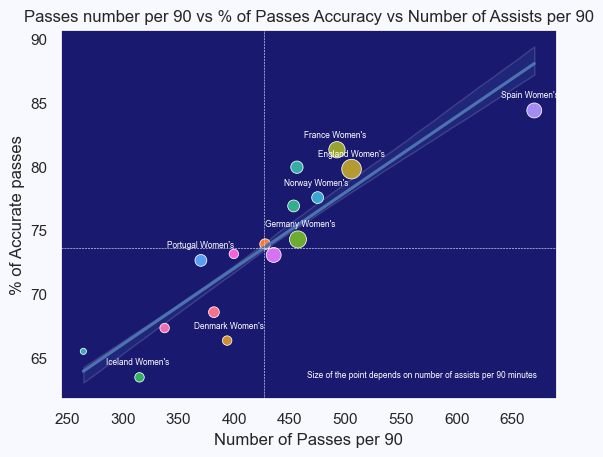

In [212]:
# Plot the chart
ax = sns.scatterplot(data=passes_df, x="passes_number/90", y="%_accuracy", hue="team", size="assists/90", sizes=(20, 200), legend=False)
ax2 = sns.regplot(data=passes_df, x="passes_number/90", y="%_accuracy", scatter=False, ci=30)

# Turns off grid on the left Axis.
ax.grid(False)
ax.annotate('Size of the point depends on number of assists per 90 minutes',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom', color = "white", fontsize=6)

# Change color
sns.set(rc={'axes.facecolor':'midnightblue', 'figure.facecolor':'ghostwhite'})

plt.title('Passes number per 90 vs % of Passes Accuracy vs Number of Assists per 90')
# Set x-axis label
plt.xlabel('Number of Passes per 90')
# Set y-axis label
plt.ylabel('% of Accurate passes')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in ["England Women's", "Spain Women's", "Germany Women's", "France Women's",
                                 "Denmark Women's", "Iceland Women's", "Norway Women's", "Portugal Women's"]:
            ax.text(point['x']-30, point['y']+1, str(point['val']), color = 'white', fontsize=6)

passes_df_without_index = passes_df.copy()
passes_df_without_index = passes_df_without_index.reset_index()
print(passes_df_without_index)
label_point(passes_df_without_index['passes_number/90'], passes_df_without_index['%_accuracy'], passes_df_without_index['team'], plt.gca())

# Plot the mean for each axis
mean_passes_number = passes_df['passes_number/90'].mean() ; mean_percent_accuracy = passes_df['%_accuracy'].mean()

#Drawing a horizontal line at point 1.25
ax.axhline(mean_percent_accuracy, linewidth = 0.4, linestyle="--", color = 'white')
ax.axvline(mean_passes_number, linewidth = 0.4, linestyle="--", color = 'white')

plt.savefig('visualizations/Passes/Passes_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Plot the passes maps of England

C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\2206664672.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['x'] = x_loc ; pass_number_raw['y'] = y_loc
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\2206664672.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_number_raw['x'] = x_loc ; pass_number_raw['y'] = y_loc
C:\Users\axelg\AppData\Local\Temp\ipykernel_10412\2206664672.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

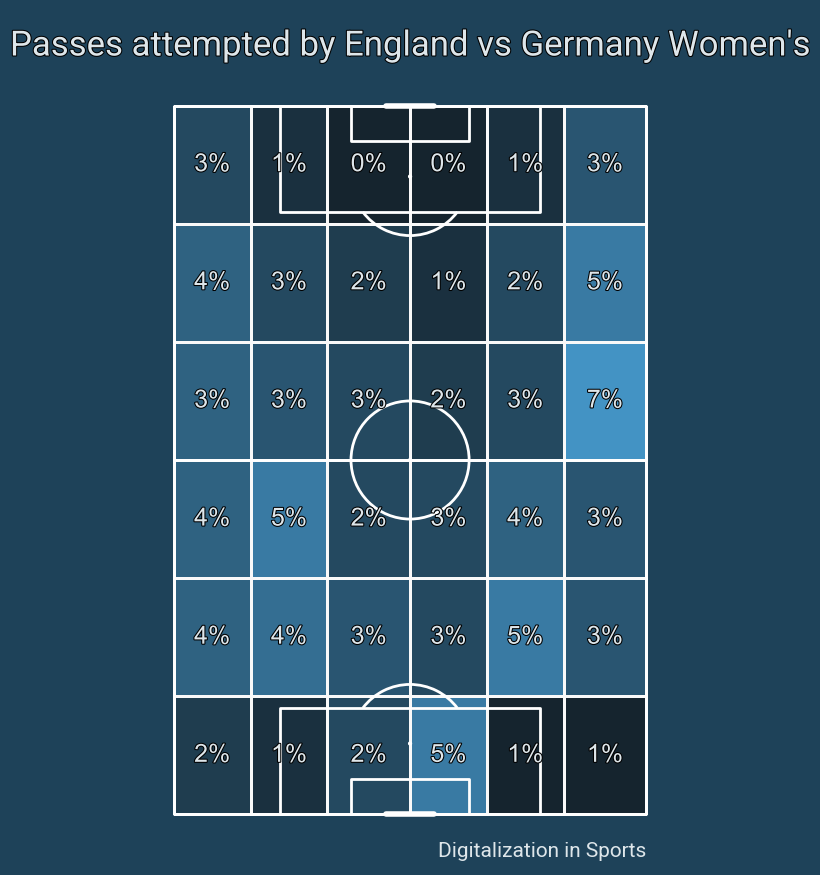

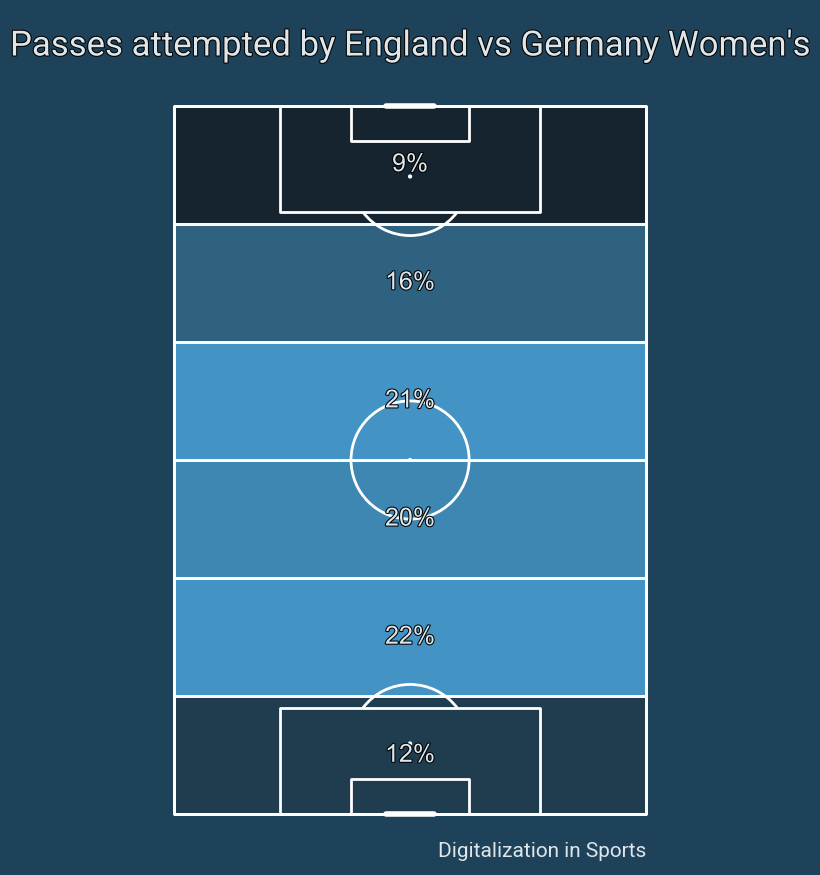

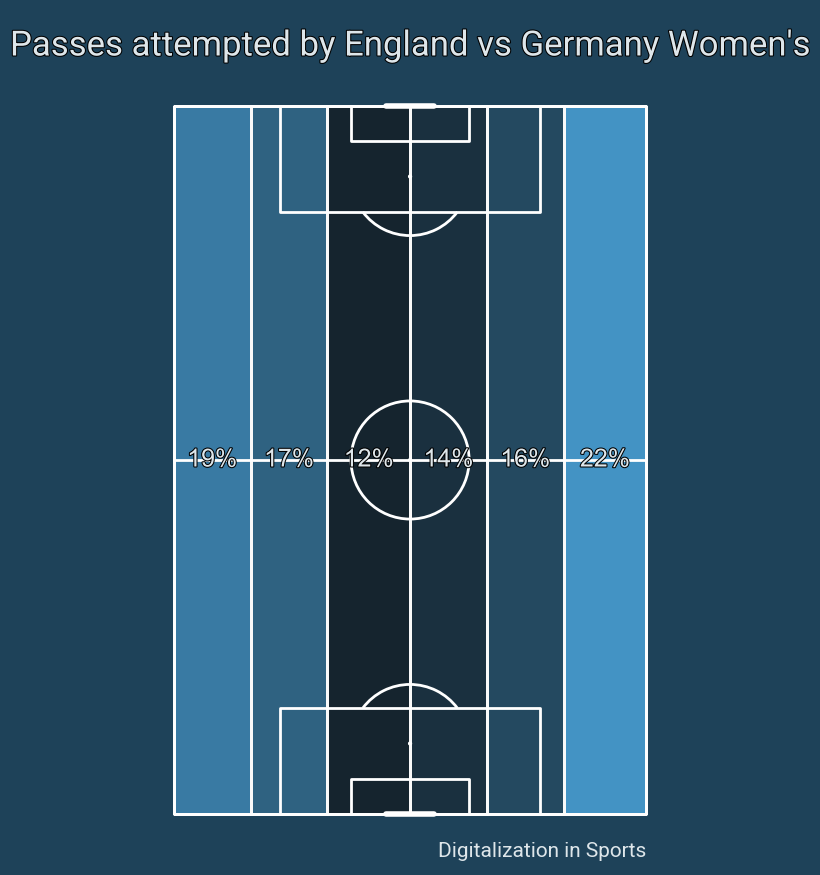

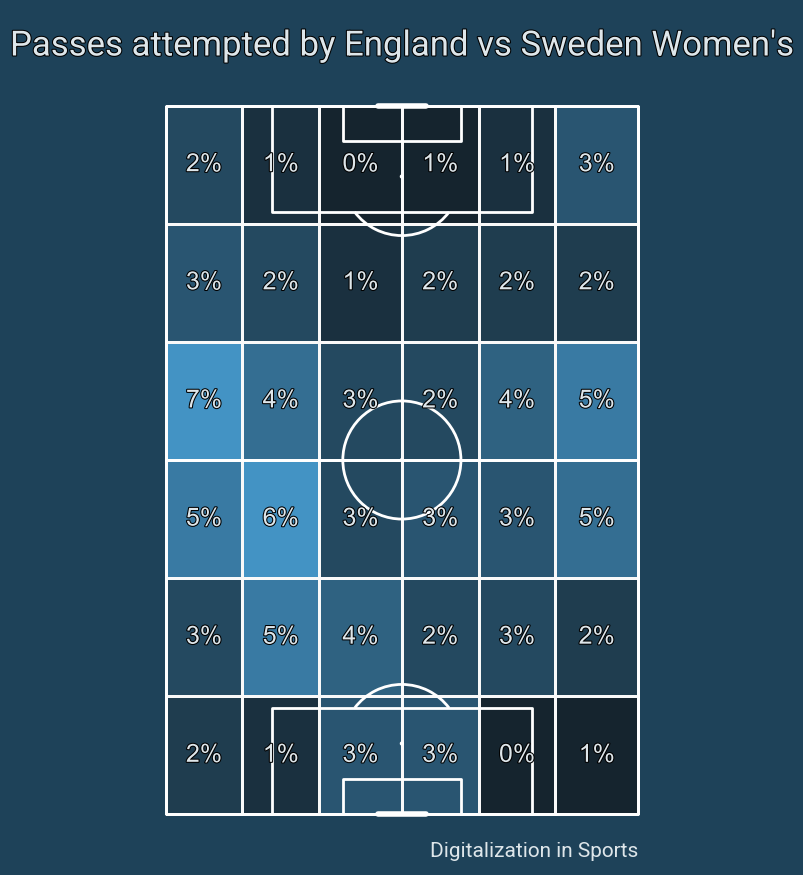

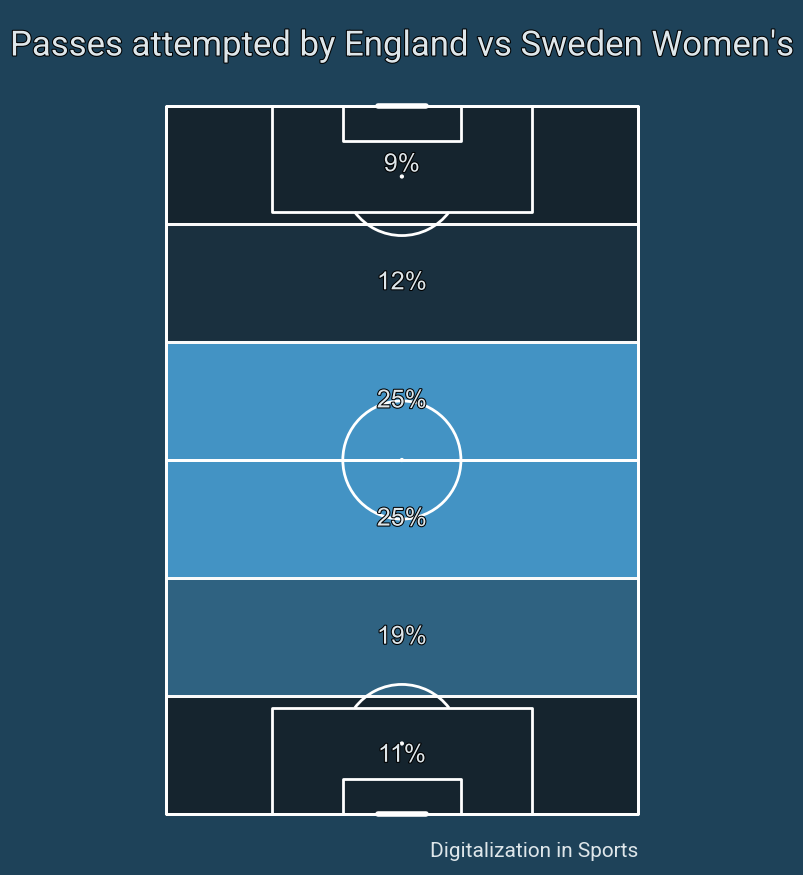

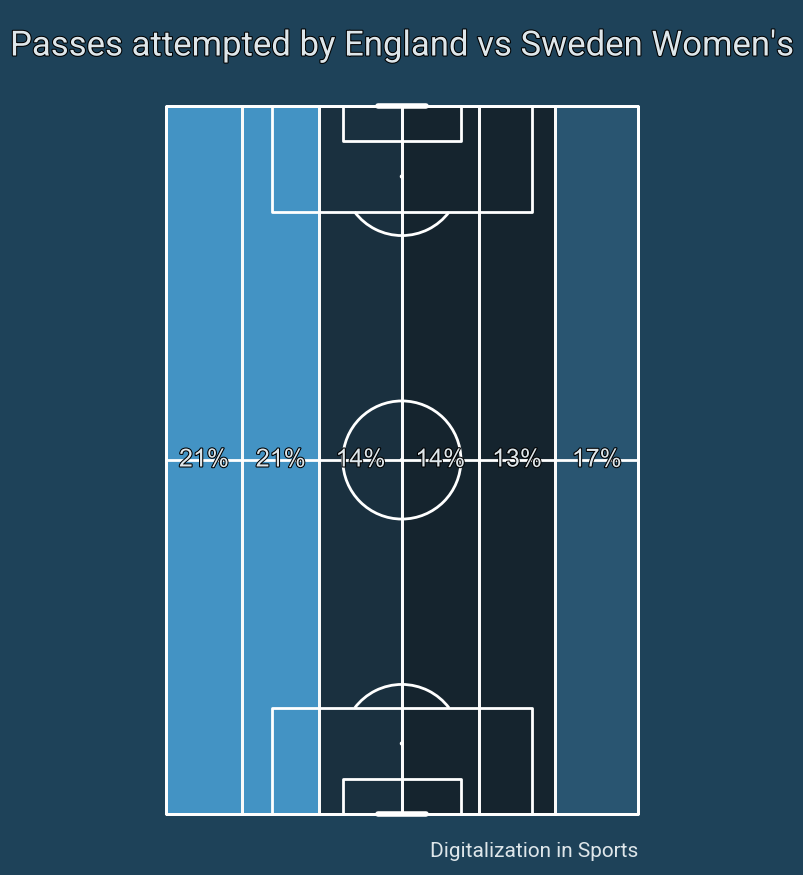

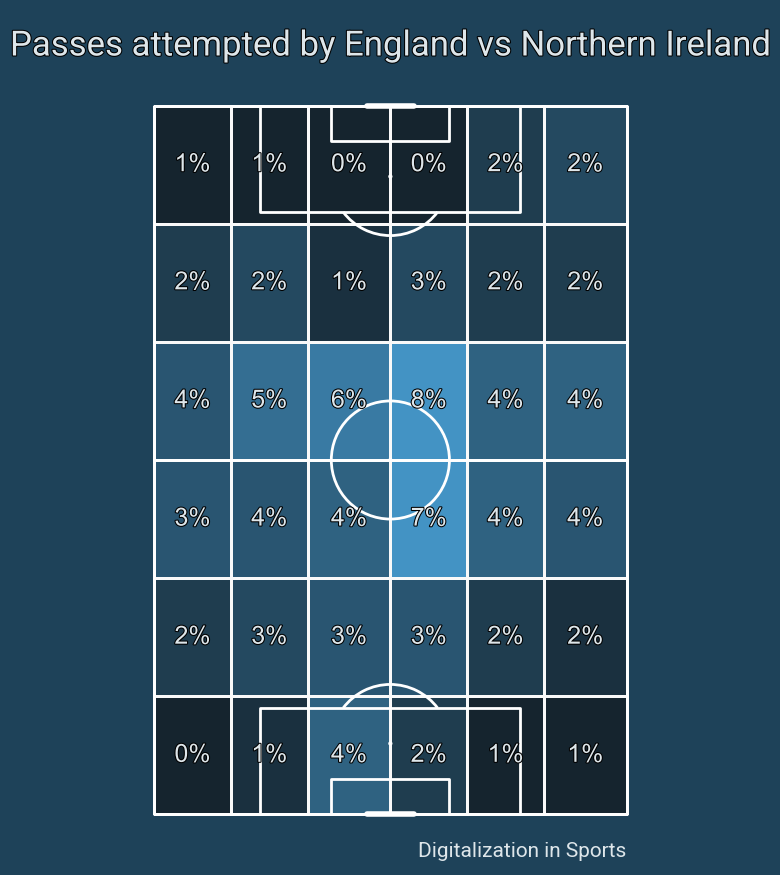

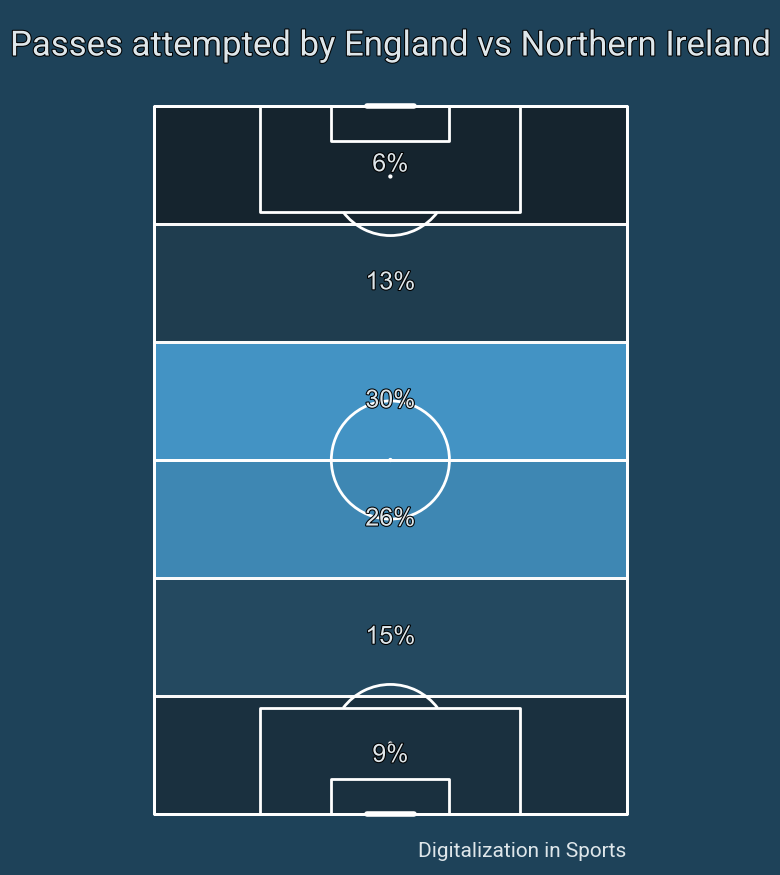

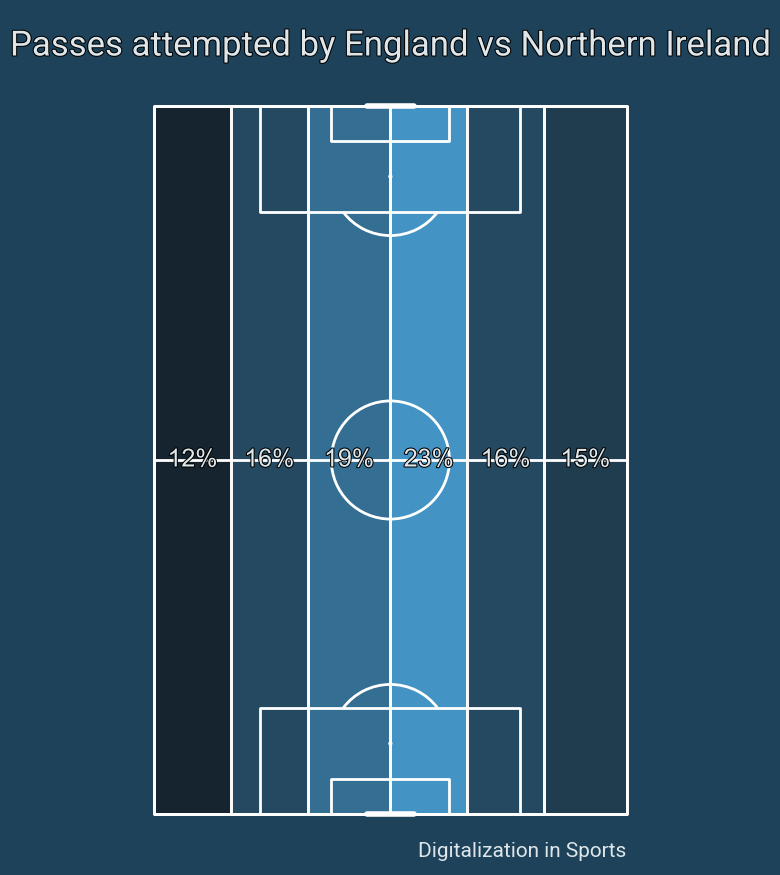

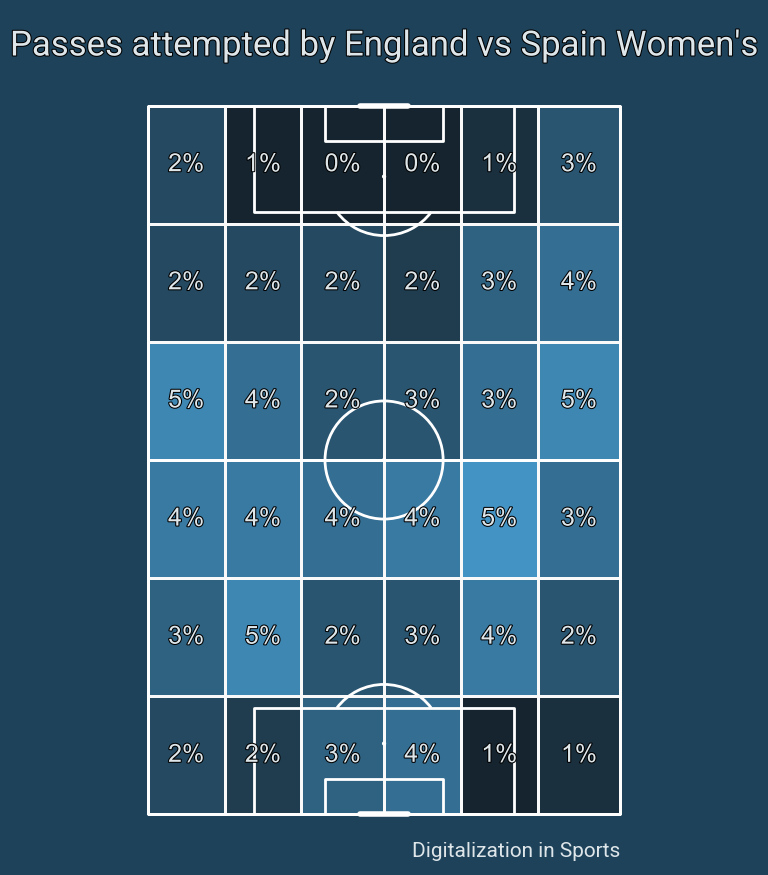

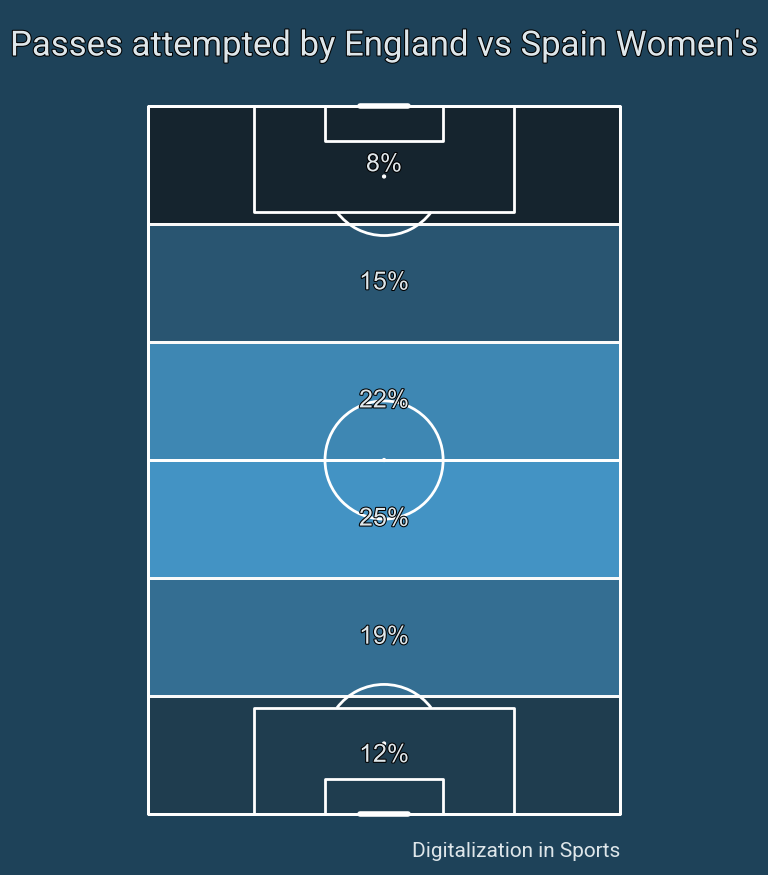

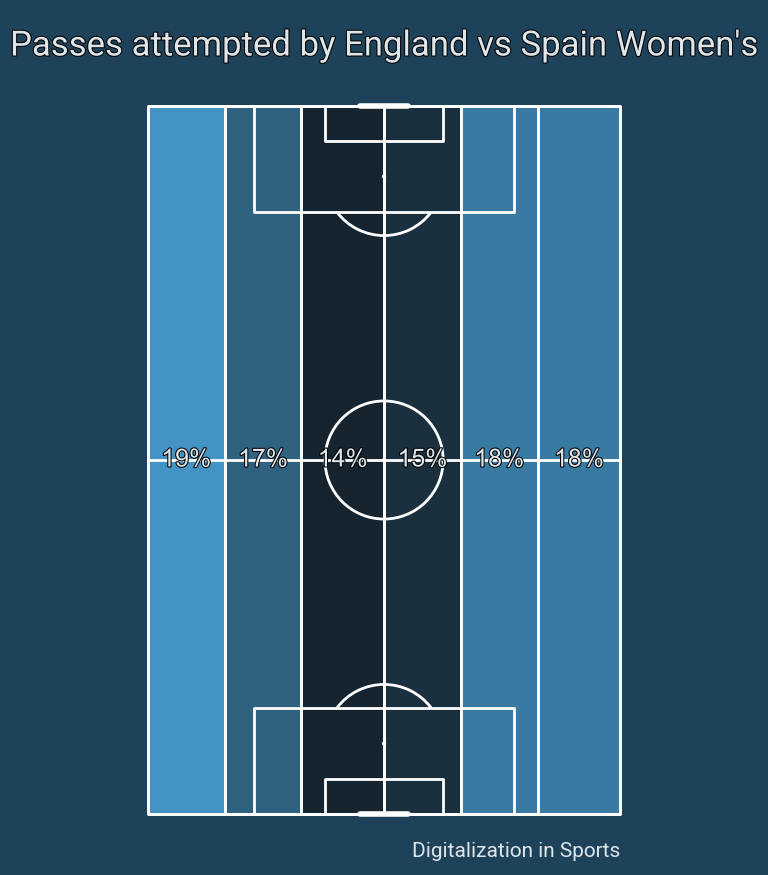

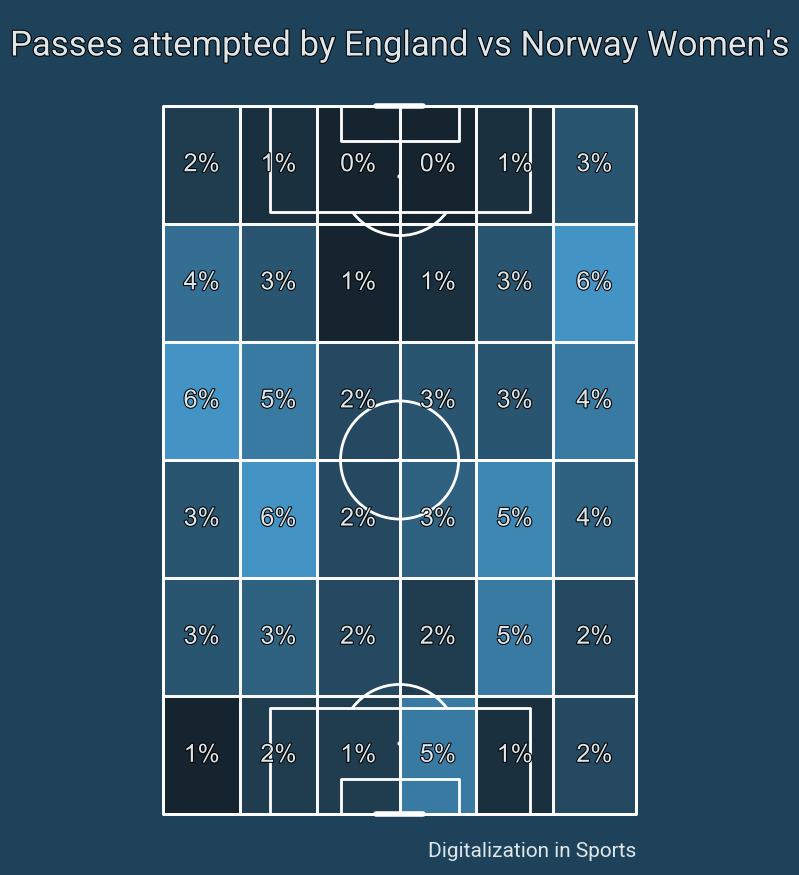

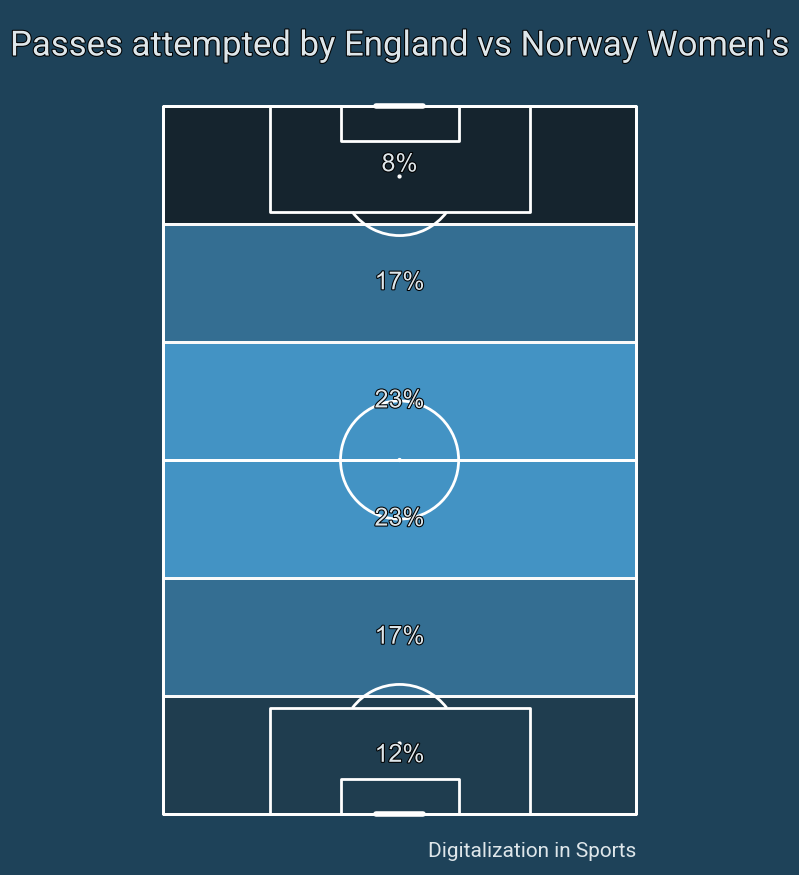

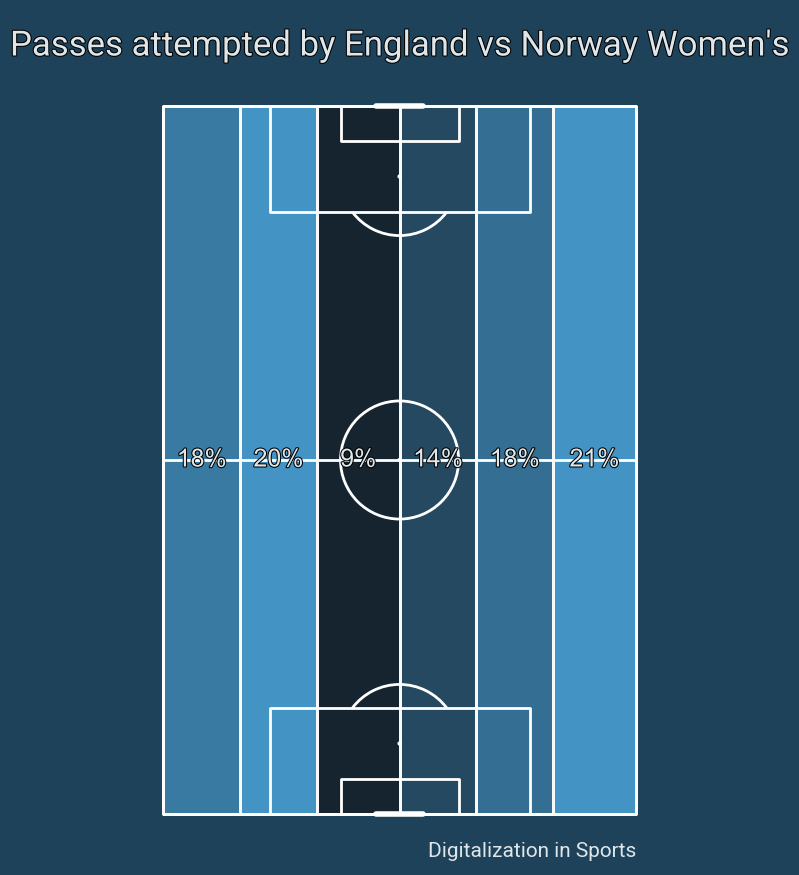

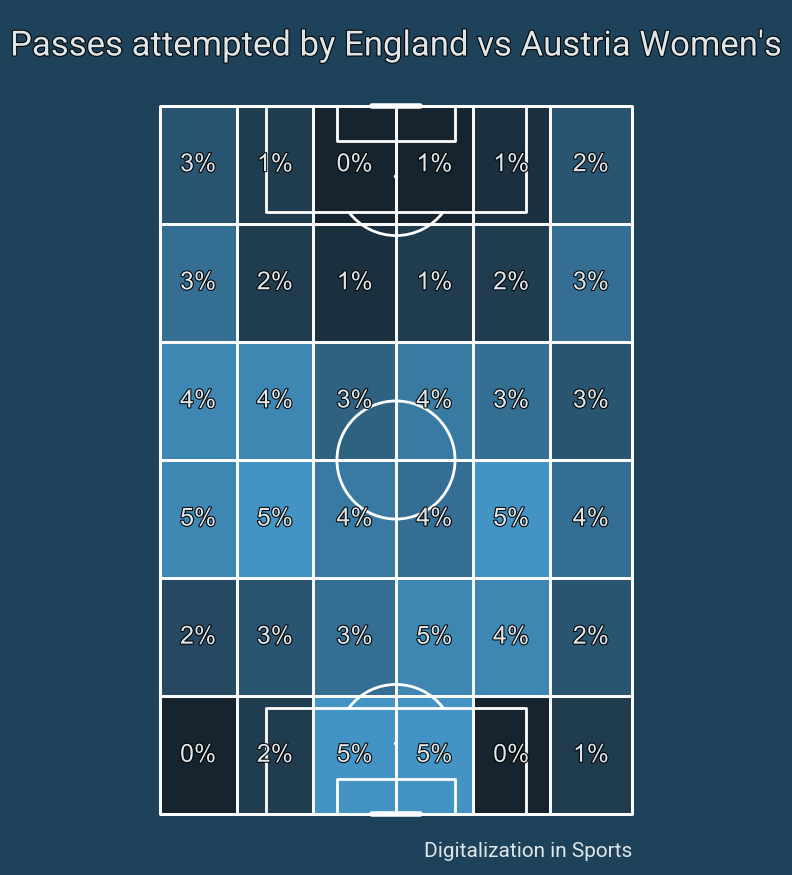

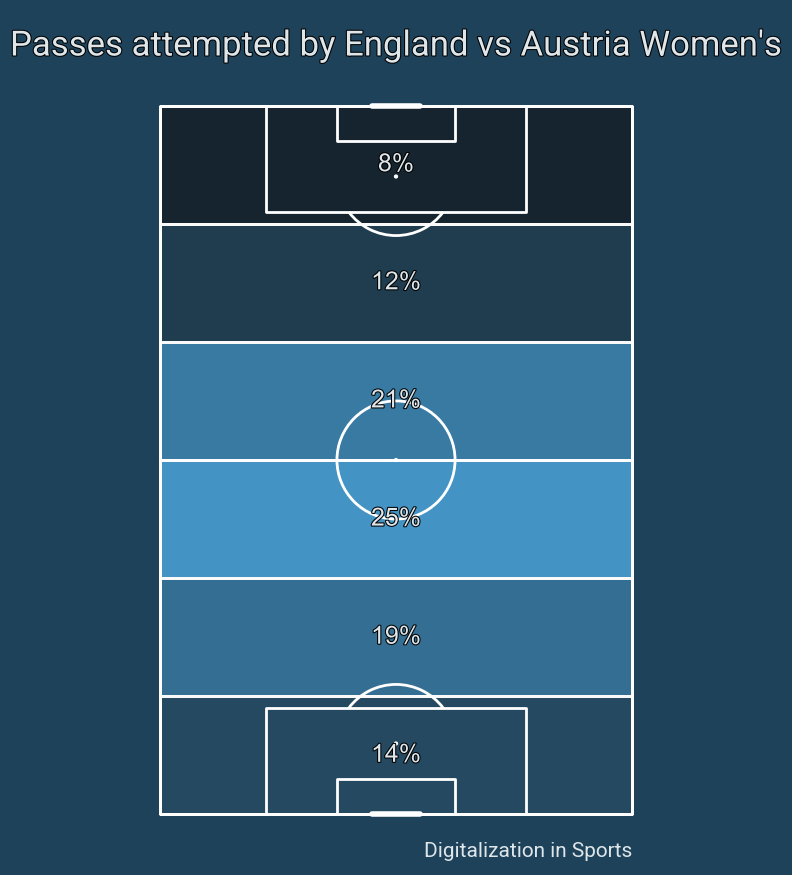

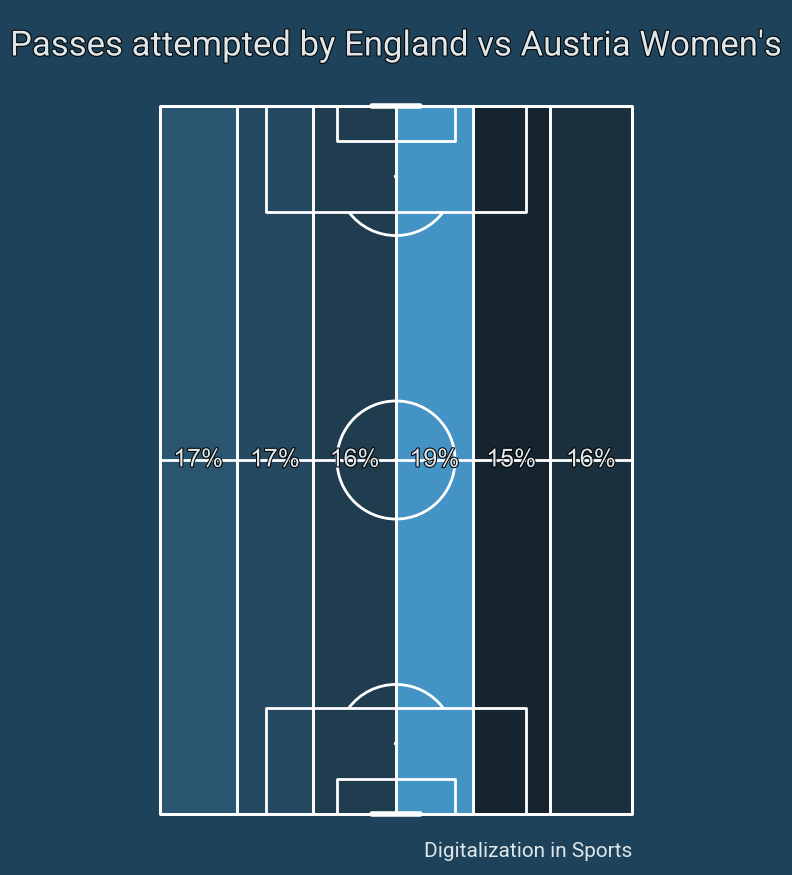

In [227]:
# Source : https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap.html

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

def compute_passing_maps(match_id):
    """"""
    # Source : https://betterprogramming.pub/how-to-visualize-football-passing-networks-using-python-6f6582aa8005

    # see the custom colormaps example for more ideas on setting colormaps
    pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)
    # path effects
    path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

    #
    robotto_regular = FontManager()

    # Get the events of the game
    game_events = sb.events(match_id)

    # Get the opponent team's name
    opponent_name = [name for name in np.unique(game_events.team.tolist()) if name != "England Women's"][0]

    # Filter the passes events
    pass_raw = game_events[game_events.type == 'Pass']
    pass_number_raw = pass_raw[['timestamp', 'location']]

    x_loc = [] ; y_loc = []
    for loc in pass_number_raw.iterrows():
        x_loc.append(loc[1][1][0]) ; y_loc.append(loc[1][1][1])
    pass_number_raw['x'] = x_loc ; pass_number_raw['y'] = y_loc

    pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#1e4259')
    fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                          title_height=0.08, title_space=0,
                          # Turn off the endnote/title axis. I usually do this after
                          # I am happy with the chart layout and text placement
                          axis=False,
                          grid_height=0.84)
    fig.set_facecolor('#1e4259')

    bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
    bin_y = [0, 13, 26, 40, 53, 66, 80]
    bin_statistic = pitch.bin_statistic(pass_number_raw.x, pass_number_raw.y, statistic='count',
                                        bins=(bin_x, bin_y), normalize=True)
    pitch.heatmap(bin_statistic, ax=axs['pitch'], cmap=pearl_earring_cmap, edgecolor='#f9f9f9')
    labels3 = pitch.label_heatmap(bin_statistic, color='#dee6ea', fontsize=18,
                                  ax=axs['pitch'], ha='center', va='center',
                                  str_format='{:.0%}', path_effects=path_eff)

    # endnote and title
    endnote_text = axs['endnote'].text(1, 0.5, 'Digitalization in Sports',
                                       va='center', ha='right', fontsize=15,
                                       fontproperties=robotto_regular.prop, color='#dee6ea')
    title_text = axs['title'].text(0.5, 0.5, "Passes attempted by England vs " + str(opponent_name),
                                   color='#dee6ea', va='center', ha='center', path_effects=path_eff,
                                   fontproperties=robotto_regular.prop, fontsize=25)
    plt.savefig('visualizations/Passes/Passing maps_'+opponent_name+'1.png', dpi=300, bbox_inches='tight')

    fig2, axs2 = pitch.grid(endnote_height=0.03, endnote_space=0,
                          title_height=0.08, title_space=0,
                          # Turn off the endnote/title axis. I usually do this after
                          # I am happy with the chart layout and text placement
                          axis=False,
                          grid_height=0.84)

    fig2.set_facecolor('#1e4259')

    bin_x = np.linspace(pitch.dim.left, pitch.dim.right, num=7)
    bin_y = [0, 80]
    bin_statistic = pitch.bin_statistic(pass_number_raw.x, pass_number_raw.y, statistic='count',
                                        bins=(bin_x, bin_y), normalize=True)
    pitch.heatmap(bin_statistic, ax=axs2['pitch'], cmap=pearl_earring_cmap, edgecolor='#f9f9f9')
    labels3 = pitch.label_heatmap(bin_statistic, color='#dee6ea', fontsize=18,
                                  ax=axs2['pitch'], ha='center', va='center',
                                  str_format='{:.0%}', path_effects=path_eff)

    # endnote and title
    endnote_text = axs2['endnote'].text(1, 0.5, 'Digitalization in Sports',
                                       va='center', ha='right', fontsize=15,
                                       fontproperties=robotto_regular.prop, color='#dee6ea')
    title_text = axs2['title'].text(0.5, 0.5, "Passes attempted by England vs " + str(opponent_name),
                                   color='#dee6ea', va='center', ha='center', path_effects=path_eff,
                                   fontproperties=robotto_regular.prop, fontsize=25)
    plt.savefig('visualizations/Passes/Passing maps_'+opponent_name+'2.png', dpi=300, bbox_inches='tight')

    fig3, axs3 = pitch.grid(endnote_height=0.03, endnote_space=0,
                          title_height=0.08, title_space=0,
                          # Turn off the endnote/title axis. I usually do this after
                          # I am happy with the chart layout and text placement
                          axis=False,
                          grid_height=0.84)

    fig3.set_facecolor('#1e4259')

    bin_x = [0, 120]
    bin_y = [0, 13, 26, 40, 53, 66, 80]
    bin_statistic = pitch.bin_statistic(pass_number_raw.x, pass_number_raw.y, statistic='count',
                                        bins=(bin_x, bin_y), normalize=True)
    pitch.heatmap(bin_statistic, ax=axs3['pitch'], cmap=pearl_earring_cmap, edgecolor='#f9f9f9')
    labels3 = pitch.label_heatmap(bin_statistic, color='#dee6ea', fontsize=18,
                                  ax=axs3['pitch'], ha='center', va='center',
                                  str_format='{:.0%}', path_effects=path_eff)

    # endnote and title
    endnote_text = axs3['endnote'].text(1, 0.5, 'Digitalization in Sports',
                                       va='center', ha='right', fontsize=15,
                                       fontproperties=robotto_regular.prop, color='#dee6ea')
    title_text = axs3['title'].text(0.5, 0.5, "Passes attempted by England vs " + str(opponent_name),
                                   color='#dee6ea', va='center', ha='center', path_effects=path_eff,
                                   fontproperties=robotto_regular.prop, fontsize=25)

    plt.savefig('visualizations/Passes/Passing maps_'+opponent_name+'3.png', dpi=300, bbox_inches='tight')

    # figure_f, axis_f = plt.subplots(1, 3)
    # axis_f[0, 0] = fig
    # axis_f[0, 1] = fig2
    # axis_f[0, 2] = fig3
    #
    # plt.show()

for i in range(6):
    compute_passing_maps(england_games_ids[i])

